In [5]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [6]:
user_action  = pd.read_csv('E:/Python/kaggle/taobao/user_action.csv')
user_action.head(10)

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21
5,93784494,337869048,1,3979,2014-12-03 20
6,94832743,105749725,1,9559,2014-12-13 20
7,95290487,76866650,1,10875,2014-11-27 16
8,96610296,161166643,1,3064,2014-12-11 23
9,100684618,21751142,3,2158,2014-12-05 23


In [7]:
user_action["user_id"] = user_action["user_id"].astype(str)
user_action["date"] = user_action["time"].map(lambda x: x.split()[0])
user_action["hour"] = user_action["time"].map(lambda x: x.split()[1])
user_action["date"] = pd.to_datetime(user_action["date"])
user_action["hour"] = user_action["hour"].astype("int64")
user_action["user_id"] = user_action["user_id"].astype(str)
user_action.head(5)

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,2
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [8]:
user_action.dtypes

user_id                  object
item_id                   int64
behavior_type             int64
item_category             int64
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

In [9]:
df = user_action.groupby('user_id').agg(
    visti_times=('user_id', 'size'),
    trans_rate=('behavior_type', lambda x: sum(x == 4) / len(x)),
    life_cycle=('date', lambda x: max(x) - min(x)),
    R=('date', lambda x: datetime(2014, 12, 18) - max(x)),
    F=('behavior_type', lambda x: sum(x == 4)),
    early_visit=('date', 'min')
).reset_index()

df.head(10)

,user_id,visti_times,trans_rate,life_cycle,R,F,early_visit
0,100001878,2768,0.013006,30 days,0 days,36,2014-11-18
1,100011562,437,0.006865,9 days,0 days,3,2014-12-09
2,100012968,388,0.038660,29 days,0 days,15,2014-11-19
3,100014060,1055,0.022749,30 days,0 days,24,2014-11-18
4,100024529,1229,0.021155,30 days,0 days,26,2014-11-18
5,100027681,2172,0.022099,30 days,0 days,48,2014-11-18
6,100035725,358,0.011173,29 days,0 days,4,2014-11-19
7,100039408,29,0.034483,18 days,11 days,1,2014-11-19
8,100042340,1371,0.002188,30 days,0 days,3,2014-11-18
9,10004287,1687,0.008299,29 days,1 days,14,2014-11-18


In [10]:
early_bought = user_action[user_action['behavior_type'] == 4].groupby('user_id')['date'].min().reset_index()
# 将两个数据框按'user_id'进行左连接
df = pd.merge(df, early_bought, on='user_id', how='left')
df.rename(columns={'date':'early_bought'}, inplace=True)
df.head(10)

,user_id,visti_times,trans_rate,life_cycle,R,F,early_visit,early_bought
0,100001878,2768,0.013006,30 days,0 days,36,2014-11-18,2014-11-18
1,100011562,437,0.006865,9 days,0 days,3,2014-12-09,2014-12-12
2,100012968,388,0.038660,29 days,0 days,15,2014-11-19,2014-11-20
3,100014060,1055,0.022749,30 days,0 days,24,2014-11-18,2014-11-18
4,100024529,1229,0.021155,30 days,0 days,26,2014-11-18,2014-11-18
5,100027681,2172,0.022099,30 days,0 days,48,2014-11-18,2014-11-18
6,100035725,358,0.011173,29 days,0 days,4,2014-11-19,2014-11-19
7,100039408,29,0.034483,18 days,11 days,1,2014-11-19,2014-11-19
8,100042340,1371,0.002188,30 days,0 days,3,2014-11-18,2014-12-18
9,10004287,1687,0.008299,29 days,1 days,14,2014-11-18,2014-11-18


In [11]:
# 将缺失值替换为指定日期
df['early_bought'] = df['early_bought'].fillna(pd.to_datetime('2014-12-18'))

# 计算waittime
df['waittime'] = df['early_bought'] - pd.to_datetime(df['early_visit'])

# 添加label列
df['label'] = np.where(df['F'] == 0, 0, 1)

In [12]:
df_kmeans = df.iloc[:,1:6]

In [13]:
df_kmeans = df_kmeans.astype('object')

In [14]:
df_kmeans["life_cycle"] = df_kmeans["life_cycle"].map(lambda x: x.days).astype("object")
df_kmeans["R"] = df_kmeans["R"].map(lambda x: x.days).astype("object")

In [15]:
df_kmeans.head(10)

,visti_times,trans_rate,life_cycle,R,F
0,2768,0.013006,30,0,36
1,437,0.006865,9,0,3
2,388,0.03866,29,0,15
3,1055,0.022749,30,0,24
4,1229,0.021155,30,0,26
5,2172,0.022099,30,0,48
6,358,0.011173,29,0,4
7,29,0.034483,18,11,1
8,1371,0.002188,30,0,3
9,1687,0.008299,29,1,14


In [16]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_kmeans)

In [17]:
scaled_data[0:10,0:5]

array([[ 1.01637453e+00, -6.89319467e-02,  5.39165904e-01,
        -3.98264039e-01,  1.25878829e+00],
       [-5.19743339e-01, -4.08289910e-01, -3.05253692e+00,
        -3.98264039e-01, -4.73525294e-01],
       [-5.52034105e-01,  1.34878324e+00,  3.68132436e-01,
        -3.98264039e-01,  1.56406919e-01],
       [-1.12484290e-01,  4.69496413e-01,  5.39165904e-01,
        -3.98264039e-01,  6.28856079e-01],
       [ 2.18087880e-03,  3.81440272e-01,  5.39165904e-01,
        -3.98264039e-01,  7.33844781e-01],
       [ 6.23613375e-01,  4.33610473e-01,  5.39165904e-01,
        -3.98264039e-01,  1.88872051e+00],
       [-5.71803962e-01, -1.70206516e-01,  3.68132436e-01,
        -3.98264039e-01, -4.21030943e-01],
       [-7.88613391e-01,  1.11794816e+00, -1.51323571e+00,
         3.04882419e+00, -5.78513996e-01],
       [ 9.57582007e-02, -6.66743703e-01,  5.39165904e-01,
        -3.98264039e-01, -4.73525294e-01],
       [ 3.04000692e-01, -3.29055808e-01,  3.68132436e-01,
        -8.48923820e-02

In [18]:
kmeansmodel = KMeans(n_clusters=4, n_init=10)
kmeansmodel.fit(scaled_data)


KMeans(n_clusters=4, n_init=10)

In [19]:
labels = kmeansmodel.labels_
df['groups'] = labels
centroids = kmeansmodel.cluster_centers_

In [20]:
df["life_cycle"] = df["life_cycle"].map(lambda x: x.days).astype("object")
df["R"] = df["R"].map(lambda x: x.days).astype("object")
df["waittime"] = df["waittime"].map(lambda x: x.days).astype("object")
df.head(10)

,user_id,visti_times,trans_rate,life_cycle,R,F,early_visit,early_bought,waittime,label,groups
0,100001878,2768,0.013006,30,0,36,2014-11-18,2014-11-18,0,1,1
1,100011562,437,0.006865,9,0,3,2014-12-09,2014-12-12,3,1,3
2,100012968,388,0.038660,29,0,15,2014-11-19,2014-11-20,1,1,2
3,100014060,1055,0.022749,30,0,24,2014-11-18,2014-11-18,0,1,0
4,100024529,1229,0.021155,30,0,26,2014-11-18,2014-11-18,0,1,0
5,100027681,2172,0.022099,30,0,48,2014-11-18,2014-11-18,0,1,1
6,100035725,358,0.011173,29,0,4,2014-11-19,2014-11-19,0,1,0
7,100039408,29,0.034483,18,11,1,2014-11-19,2014-11-19,0,1,3
8,100042340,1371,0.002188,30,0,3,2014-11-18,2014-12-18,30,1,0
9,10004287,1687,0.008299,29,1,14,2014-11-18,2014-11-18,0,1,0


In [21]:
df.head(10)

,user_id,visti_times,trans_rate,life_cycle,R,F,early_visit,early_bought,waittime,label,groups
0,100001878,2768,0.013006,30,0,36,2014-11-18,2014-11-18,0,1,1
1,100011562,437,0.006865,9,0,3,2014-12-09,2014-12-12,3,1,3
2,100012968,388,0.038660,29,0,15,2014-11-19,2014-11-20,1,1,2
3,100014060,1055,0.022749,30,0,24,2014-11-18,2014-11-18,0,1,0
4,100024529,1229,0.021155,30,0,26,2014-11-18,2014-11-18,0,1,0
5,100027681,2172,0.022099,30,0,48,2014-11-18,2014-11-18,0,1,1
6,100035725,358,0.011173,29,0,4,2014-11-19,2014-11-19,0,1,0
7,100039408,29,0.034483,18,11,1,2014-11-19,2014-11-19,0,1,3
8,100042340,1371,0.002188,30,0,3,2014-11-18,2014-12-18,30,1,0
9,10004287,1687,0.008299,29,1,14,2014-11-18,2014-11-18,0,1,0


In [22]:
G0T = df.loc[df["groups"] == 0, 'waittime']

kmf = KaplanMeierFitter()

C:\Users\l4241\anaconda3\envs\lyh\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\l4241\anaconda3\envs\lyh\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\l4241\anaconda3\envs\lyh\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\l4241\anac

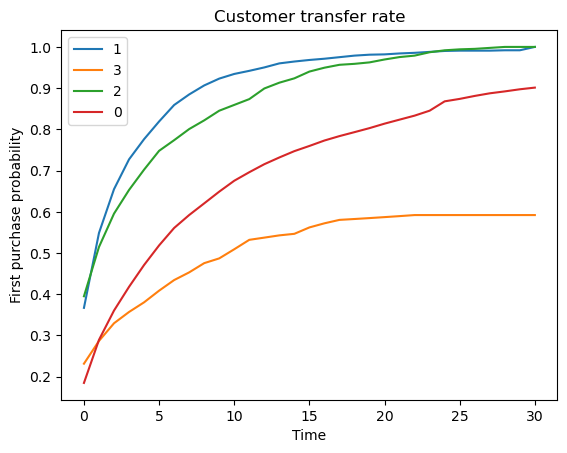

In [25]:
fig, ax = plt.subplots()
x = np.arange(0,31,1)
for i in df['groups'].unique():
    idx = df['groups']==i
    kmf = KaplanMeierFitter()
    kmf.fit(df[idx]['waittime'], event_observed=df[idx]["label"], label=i)
    survival_prob = kmf.survival_function_.values
    padded_arr = np.pad(survival_prob, ((0, 31-len(survival_prob)), (0, 0)), 'constant', constant_values=0)
    padded_arr = 1 - padded_arr
    ax.plot(x, padded_arr, label = i)

# 添加图例
ax.legend()

# 设置坐标轴标签
ax.set_xlabel('Time')
ax.set_ylabel('First purchase probability')

# 设置图标题
ax.set_title('Customer transfer rate')

# 显示图形
plt.show()

C:\Users\l4241\anaconda3\envs\lyh\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\l4241\anaconda3\envs\lyh\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\l4241\anaconda3\envs\lyh\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\l4241\anac

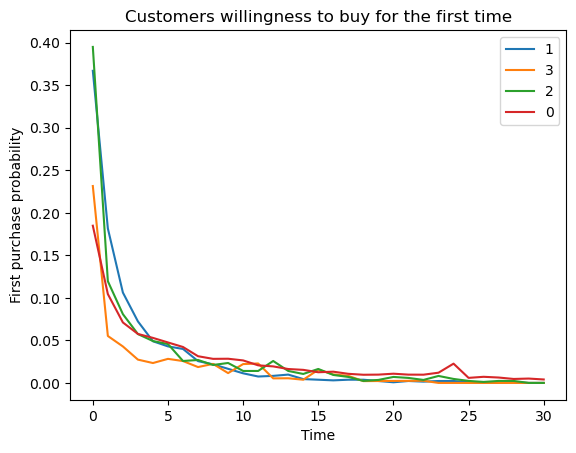

In [26]:
fig, ax = plt.subplots()
x = np.arange(0,31,1)
for i in df['groups'].unique():
    idx = df['groups']==i
    kmf = KaplanMeierFitter()
    kmf.fit(df[idx]['waittime'], event_observed=df[idx]["label"], label=i)
    survival_prob = kmf.survival_function_.values
    survival_prob_diff = np.diff(np.insert(survival_prob,0,1))
    padded_arr = np.pad(survival_prob_diff, (0, 31 - len(survival_prob_diff)), 'constant')
    padded_arr = -padded_arr
    ax.plot(x, padded_arr, label = i)

# 添加图例
ax.legend()

# 设置坐标轴标签
ax.set_xlabel('Time')
ax.set_ylabel('First purchase probability')

# 设置图标题
ax.set_title('Customers willingness to buy for the first time')

# 显示图形
plt.show()
